# 深層学習ノートブック-12 Optimizer
学習ループのコードの保守性を高めるために、パラメータの更新する部分をOptimizerクラスにまとめる。  
* 学習の対象となるparametersおよびlr(学習率)をインスタンスの引数に渡す
* step()メソッドにて各パラメータを更新する処理を記述する
* zero_grad()メソッドにて各パラメータの勾配をゼロにする処理を記述する  

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

In [40]:
import torch
from torch import nn
from torch.nn import functional as F
# Optimizerのimport
from torch import optim


import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## ■ まずはpytorchのクラスを使わずに実装

In [34]:
class Optimizer():
    def __init__(self, parameters, lr=0.03) -> None:
        '''
        parameters: nn.Module.parameters(genarator)
        lr: learning rate
        '''
        self.parameters = list(parameters)
        self.lr = lr

    # パラメタを更新するためのメソッド
    # paramにはself.parametersから参照渡ししているので、paramが更新されれば
    # self.parametersも更新される。
    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad


    def zero_grad(self):
        for param in self.parameters:
                # paramがNoneではない場合、ゼロにする
                if param is not None:
                     param.grad.zero_()

In [35]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # 全結合層はパラメタを持つのでnn.で定義する
        # num_in, num_hidden, num_outを渡すことにより全結合層を実体化させる
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # デバッグ用
        # z1 = self.linear_1(z)
        # a1 = F.relu(z1)
        # z2 = self.linear_2(a1)
        # 隠れ層の線形変換 →ReLu適用→ 隠れ層の線形変換を一気にやっている。
        z = self.linear_2( F.relu( self.linear_1(x)) )
        return z

In [36]:
# MNISTデータセットの読み込み
dataset = datasets.load_digits()
X = torch.tensor( dataset.data , dtype=torch.float32) 
y = torch.tensor( dataset.target)
# ★ F.cross_entropyの仕様的にはone_hotの形にする必要はない
# y = F.one_hot(y, num_classes=10) 

# hold-out
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
train_mean, train_std = X_train.mean(), X_train.std()
X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std

# モデルのコンストラクタに渡す引数を定義
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)
# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# Optimizerのインスタンスを生成
opt = Optimizer(MLP_model.parameters(), 0.03)

In [38]:
# バッチサイズとバッチの個数を定義
batch_size = 32
num_batches = X_train.shape[0] // batch_size + 1
learning_rate = 0.03

# 学習・検証結果格納用辞書
train_results = {}

for i, _ in enumerate(range(100)):
    #　インデックスをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))

    # shuffled_indicesからの取り出し範囲初期化
    idx_start = 0
    idx_end = batch_size

    # 各バッチでの学習データに対するlossを累積する用の変数
    cum_loss = 0

    for _ in range(num_batches):
        # 学習データ定義
        indices_train = shuffled_indices[ idx_start:idx_end ]
        X_train_batch = X_train[indices_train]
        y_train_batch = y_train[indices_train]

        # 順伝播の計算。F.cross_entropyの中でsoftmaxが適用されるので適用不要
        #y_pred = F.softmax(MLP_model(X_train_batch), dim=1)
        y_pred = MLP_model(X_train_batch)

        # 損失計算
        loss = F.cross_entropy(y_pred , y_train_batch)
        cum_loss += loss.item()
        # 逆伝播の計算
        loss.backward()

        # パラメタ更新
        # with torch.no_grad():
        #     for params in MLP_model.parameters():
        #         params -= learning_rate * params.grad
        # 実装したOptimizerクラスを用いてパラメタ更新
        opt.step()

        # 勾配初期化。nn.Moduleから継承しているので.zero_gradはそのまま使える。
        # MLP_model.zero_grad()
        opt.zero_grad()

        # 取り出し範囲更新
        idx_start += batch_size
        idx_end += batch_size
    
    # 検証データに対する損失を計算
    y_pred_val = MLP_model(X_val)
    loss_val = F.cross_entropy(y_pred_val, y_val)

    # 損失、accuracyを記録
    train_results[f"epoch_{i}"] = {
        "Loss_train": cum_loss / num_batches,
        "Loss_val": loss_val.item(),
        "Accuracy": ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) ).item()
    }

    print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


epoch_0: {'Loss_train': 2.1782985395855374, 'Loss_val': 2.018054962158203, 'Accuracy': 0.4472222328186035}
epoch_1: {'Loss_train': 1.7752311176723905, 'Loss_val': 1.5459049940109253, 'Accuracy': 0.6583333611488342}
epoch_2: {'Loss_train': 1.277741018931071, 'Loss_val': 1.046456217765808, 'Accuracy': 0.824999988079071}
epoch_3: {'Loss_train': 0.8702525854110718, 'Loss_val': 0.713523805141449, 'Accuracy': 0.8666666746139526}
epoch_4: {'Loss_train': 0.6226674569977655, 'Loss_val': 0.5214605331420898, 'Accuracy': 0.9083333611488342}
epoch_5: {'Loss_train': 0.47573417358928255, 'Loss_val': 0.42400309443473816, 'Accuracy': 0.9111111164093018}
epoch_6: {'Loss_train': 0.3902395659022861, 'Loss_val': 0.3474915325641632, 'Accuracy': 0.925000011920929}
epoch_7: {'Loss_train': 0.3307853182156881, 'Loss_val': 0.30688270926475525, 'Accuracy': 0.925000011920929}
epoch_8: {'Loss_train': 0.29012054536077714, 'Loss_val': 0.2727046012878418, 'Accuracy': 0.9277777671813965}
epoch_9: {'Loss_train': 0.25963

# ●学習曲線の描画
学習データと検証データでの損失の推移を確認してみる。

In [32]:
loss_per_epoch_train = []
loss_per_epoch_val = []

for result in train_results.values():
    loss_per_epoch_train.append(result['Loss_train'])
    loss_per_epoch_val.append(result['Loss_val'])

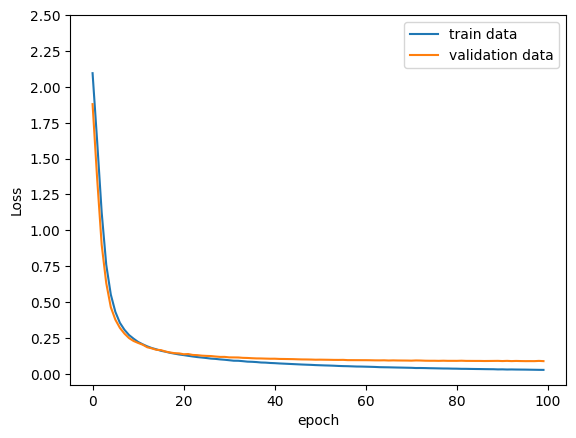

In [33]:
plt.plot(loss_per_epoch_train, label='train data')
plt.plot(loss_per_epoch_val, label='validation data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 2.5, 11))
plt.legend()

------------------------------------
## ■ Pytorchのtorch.optimクラスでパラメタ最適化
* torch.optimクラスではNNモデルのパラメータ更新の際の様々な最適化アルゴリズムを提供  
  最適化の方法は今まで見てきた最急降下法以外にもいろいろある。  
* 勾配降下法を使用してモデルのパラメータを更新し，損失を最小化してくれる
* 以下のようなOptimizerが実装されている
    * torch.opbm.SGD　※上記の実装と同様のもの。SGD: Stochastic Gradient Descent
    * torch.opbm.Momentum
    * torch.opbm.RMSProp
    * torch.opbm.Adam　※よく使う
* モデルのパラメータ(model.parameters())と，学習率(lr)を渡してインスタンスを生成
* .step()でパラメータを更新
* .zero_grad()でパラメータの勾配をNoneにリセット

In [50]:
# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)
# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optim_torch = optim.SGD(MLP_model.parameters(), lr=0.03)

In [51]:
# バッチサイズとバッチの個数を定義
batch_size = 32
num_batches = X_train.shape[0] // batch_size + 1
learning_rate = 0.03

# 学習・検証結果格納用辞書
train_results = {}

for i, _ in enumerate(range(100)):
    #　インデックスをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))

    # shuffled_indicesからの取り出し範囲初期化
    idx_start = 0
    idx_end = batch_size

    # 各バッチでの学習データに対するlossを累積する用の変数
    cum_loss = 0

    for _ in range(num_batches):
        # 学習データ定義
        indices_train = shuffled_indices[ idx_start:idx_end ]
        X_train_batch = X_train[indices_train]
        y_train_batch = y_train[indices_train]

        # 順伝播の計算。F.cross_entropyの中でsoftmaxが適用されるので適用不要
        #y_pred = F.softmax(MLP_model(X_train_batch), dim=1)
        y_pred = MLP_model(X_train_batch)

        # 損失計算
        loss = F.cross_entropy(y_pred , y_train_batch)
        cum_loss += loss.item()
        # 逆伝播の計算
        loss.backward()

        # パラメタ更新
        # with torch.no_grad():
        #     for params in MLP_model.parameters():
        #         params -= learning_rate * params.grad
        # 実装したOptimizerクラスを用いてパラメタ更新
        optim_torch.step()

        # 勾配初期化。nn.Moduleから継承しているので.zero_gradはそのまま使える。
        # MLP_model.zero_grad()
        optim_torch.zero_grad()

        # 取り出し範囲更新
        idx_start += batch_size
        idx_end += batch_size
    
    # 検証データに対する損失を計算
    y_pred_val = MLP_model(X_val)
    loss_val = F.cross_entropy(y_pred_val, y_val)

    # 損失、accuracyを記録
    train_results[f"epoch_{i}"] = {
        "Loss_train": cum_loss / num_batches,
        "Loss_val": loss_val.item(),
        "Accuracy": ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) ).item()
    }

    print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


epoch_0: {'Loss_train': 2.1334453026453652, 'Loss_val': 1.9139227867126465, 'Accuracy': 0.5638889074325562}
epoch_1: {'Loss_train': 1.6540952603022256, 'Loss_val': 1.3794052600860596, 'Accuracy': 0.7638888955116272}
epoch_2: {'Loss_train': 1.143251978026496, 'Loss_val': 0.9410049319267273, 'Accuracy': 0.8777777552604675}
epoch_3: {'Loss_train': 0.783967755900489, 'Loss_val': 0.6448764801025391, 'Accuracy': 0.9138888716697693}
epoch_4: {'Loss_train': 0.570439213514328, 'Loss_val': 0.4894690215587616, 'Accuracy': 0.925000011920929}
epoch_5: {'Loss_train': 0.4404057184855143, 'Loss_val': 0.39046478271484375, 'Accuracy': 0.9277777671813965}
epoch_6: {'Loss_train': 0.3618222494920095, 'Loss_val': 0.3285788595676422, 'Accuracy': 0.9361110925674438}
epoch_7: {'Loss_train': 0.30878644386927284, 'Loss_val': 0.28534895181655884, 'Accuracy': 0.9444444179534912}
epoch_8: {'Loss_train': 0.27153442137771183, 'Loss_val': 0.2566598355770111, 'Accuracy': 0.9444444179534912}
epoch_9: {'Loss_train': 0.24

手で実装した結果とさほどは変わらない。  
他の最適化手法は今後追記。